# EMNIST dataset using CNN

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data  import DataLoader,TensorDataset
import copy 
from sklearn.model_selection import train_test_split

# for importin data 
import torchvision

import matplotlib.pyplot as plt

In [3]:
cdata = torchvision.datasets.EMNIST(root='../data/emnist', split='letters', download=False)

In [3]:
# inspect the data
print(cdata.classes)
print(len(cdata.classes))

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27


In [4]:
print(cdata.data.shape)

torch.Size([124800, 28, 28])


In [9]:
# we notice that the dataset doesn't containe the rgb dimension so we will add it since the CNN requires it
images = cdata.data.reshape(cdata.data.shape[0], 1, 28, 28).float()
print(images.shape)

torch.Size([124800, 1, 28, 28])


In [5]:
print(torch.sum(cdata.targets == 0))
print(torch.unique(cdata.targets))

tensor(0)
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])


In [11]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [4]:
letter_categories = cdata.classes[1:] # # remove the first class which is '0' 'N/A'
letter_categories

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
labels = copy.deepcopy(cdata.targets) - 1 # relable the labels to start from 0
labels.shape

torch.Size([124800])

In [6]:
torch.unique(labels)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

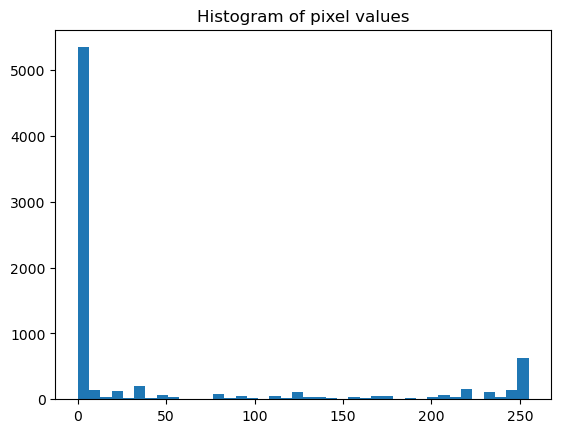

In [13]:
# Do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Histogram of pixel values')
plt.show()

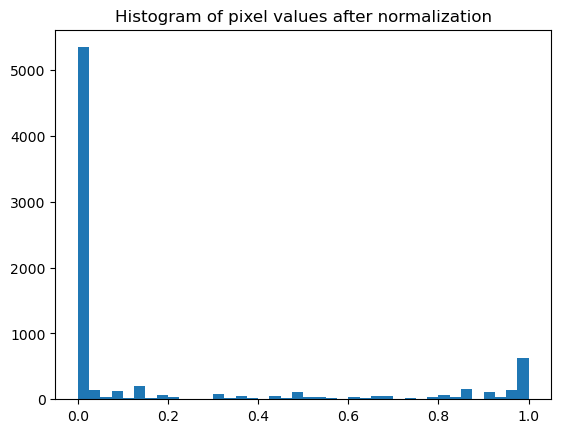

In [14]:
# We notice that our data is not normalized so we will normalize it
images /= torch.max(images) 
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Histogram of pixel values after normalization')
plt.show()

In [15]:
# visualize some images
def plot_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(letter_categories[labels[i]])
        ax.axis('off')
    plt.show()

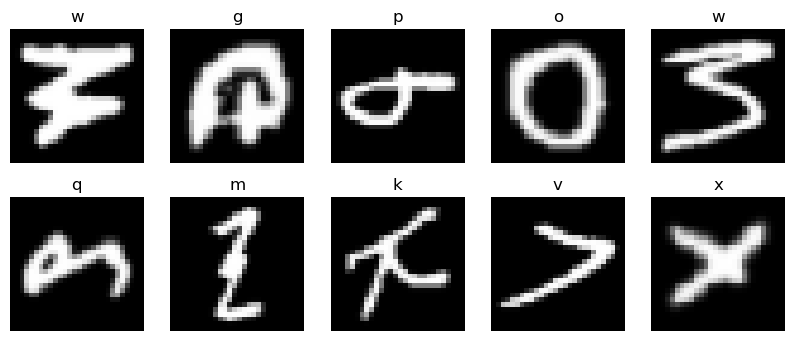

In [16]:
plot_images(images[:10], labels[:10])

## Create test/train partitions using DataLoader

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=42)

# Convert into PyTorch tensors
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
print(train_data.tensors[0].shape)
print(train_data.tensors[1].shape)

# Create DataLoader for training and testing
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [19]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


## Create the model

In [22]:
def makeTheNet(printtogle=False):
    class EmnistCNN(nn.Module):
        def __init__(self,printtogle=False):
            super().__init__()

            self.print = printtogle
            self.conv1 = nn.Conv2d(1,6,3,padding=1) # 28x28x1 -> 28x28x6
            self.bnorm1 = nn.BatchNorm2d(6)

            self.conv2 = nn.Conv2d(6,6,3,padding=1) 
            self.bnorm2 = nn.BatchNorm2d(6)

            self.fc1 = nn.Linear(7*7*6, 50)
            self.fc2 = nn.Linear(50, 26)

        def forward(self, x):
            if self.print:
                print(f"Input shape: {list(x.shape)}")

            # first block: conv -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2) 
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # second block: conv -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:
                print(f"Second CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:
                print(f"Output shape: {list(x.shape)}")
            return x


    net = EmnistCNN(printtogle=printtogle)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


    return net, loss, optimizer                    

In [28]:
net , lossfun, optimizer = makeTheNet(printtogle=False)

In [29]:
X, y = next(iter(train_loader))
yHat = net(X)
print(yHat.shape) # 32x26 batch size x number of classes
print(yHat[0]) # 26 classes

torch.Size([32, 26])
tensor([ 0.1917, -0.0819, -0.1336, -0.2244,  0.2140,  0.0887,  0.5115,  0.0575,
        -0.3255, -0.3146, -0.1269, -0.1531, -0.0823, -0.1247,  0.0388, -0.1618,
        -0.4314, -0.0430, -0.1696, -0.0767, -0.2733, -0.0954,  0.0253, -0.2908,
         0.1089,  0.0517], grad_fn=<SelectBackward0>)


In [31]:
loss = lossfun(yHat, torch.squeeze(y))
print(loss)

tensor(3.3176, grad_fn=<NllLossBackward0>)


In [38]:
def fucntion2trainThemodel(net, lossfun, optimizer, train_loader, epochs=10):
    trainlosses = torch.zeros(epochs)
    testlosses = torch.zeros(epochs)
    trainErr = torch.zeros(epochs)
    testErr = torch.zeros(epochs)

    for epoch in range(epochs):
        net.train() 
        batchloss = []
        batchErr = []

        for X,y in train_loader: 

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and error from this batch 
            batchloss.append(loss.item())
            batchErr.append(torch.mean((torch.argmax(yHat,1) != y).float()).item())

            # end of batch loop

        trainlosses[epoch] = np.mean(batchloss)    
        trainErr[epoch] = 100* np.mean(batchErr)

        net.eval() # set the model to evaluation mode
        X,y = next(iter(test_loader)) # get the test data
        with torch.no_grad():
            yHat = net(X) # forward pass
            loss = lossfun(yHat, y)
            
        testlosses[epoch] = loss.item()
        testErr[epoch] = 100* torch.mean((torch.argmax(yHat,1) != y).float()).item()
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {trainlosses[epoch]:.4f}, Train Error: {trainErr[epoch]:.2f}%, Test Loss: {testlosses[epoch]:.4f}, Test Error: {testErr[epoch]:.2f}%")
  
    return trainlosses, testlosses, trainErr, testErr

In [39]:
fucntion2trainThemodel(net, lossfun, optimizer, train_loader, epochs=10)

Epoch 1/10: Train Loss: 0.2538, Train Error: 8.50%, Test Loss: 0.2524, Test Error: 8.55%
Epoch 2/10: Train Loss: 0.2418, Train Error: 8.09%, Test Loss: 0.2594, Test Error: 8.60%
Epoch 3/10: Train Loss: 0.2334, Train Error: 7.88%, Test Loss: 0.2521, Test Error: 8.19%
Epoch 4/10: Train Loss: 0.2230, Train Error: 7.51%, Test Loss: 0.2450, Test Error: 8.14%
Epoch 5/10: Train Loss: 0.2179, Train Error: 7.48%, Test Loss: 0.2363, Test Error: 8.10%
Epoch 6/10: Train Loss: 0.2129, Train Error: 7.23%, Test Loss: 0.2361, Test Error: 7.64%
Epoch 7/10: Train Loss: 0.2071, Train Error: 7.14%, Test Loss: 0.2466, Test Error: 7.95%
Epoch 8/10: Train Loss: 0.2023, Train Error: 6.99%, Test Loss: 0.2464, Test Error: 8.08%
Epoch 9/10: Train Loss: 0.1980, Train Error: 6.82%, Test Loss: 0.2306, Test Error: 7.63%
Epoch 10/10: Train Loss: 0.1945, Train Error: 6.76%, Test Loss: 0.2529, Test Error: 8.61%


(tensor([0.2538, 0.2418, 0.2334, 0.2230, 0.2179, 0.2129, 0.2071, 0.2023, 0.1980,
         0.1945]),
 tensor([0.2524, 0.2594, 0.2521, 0.2450, 0.2363, 0.2361, 0.2466, 0.2464, 0.2306,
         0.2529]),
 tensor([8.5016, 8.0921, 7.8793, 7.5098, 7.4777, 7.2338, 7.1359, 6.9916, 6.8153,
         6.7575]),
 tensor([8.5497, 8.5978, 8.1891, 8.1410, 8.1010, 7.6362, 7.9487, 8.0769, 7.6282,
         8.6058]))